<a href="https://colab.research.google.com/github/taniasahu/Automatic-Modulation-Classification-/blob/main/ResNet_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy -q
!pip install tensorflow -q
!pip install scipy -q
!pip install matplotlib -q
!pip install keras -q
!pip install scikit-learn -q

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to file location in Google Drive
file_path = '/content/drive/My Drive/AMC_dataset.mat'

Mounted at /content/drive


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
from scipy.io import loadmat

# Load dataset (assuming file_path is defined)
data = loadmat(file_path)
X = data['data']  # Shape: (55000, 1024, 2)
y = data['labels'].flatten() - 1  # 0-based indexing
split = data['split'].flatten()  # 0=train, 1=val, 2=test

# Split dataset
X_train = X[split == 0]
y_train = y[split == 0]
X_val = X[split == 1]
y_val = y[split == 1]
X_test = X[split == 2]
y_test = y[split == 2]

# Define residual block
def residual_block(x, filters, stride=1):
    shortcut = x
    x = layers.Conv1D(filters, 1, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(filters, 3, strides=stride, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    if stride > 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, strides=stride, padding='same', kernel_initializer='he_normal')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# Build CNN model with increased capacity
def build_cnn_model(input_shape=(1024, 2), num_classes=11):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(128, 7, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(3, strides=2, padding='same')(x)

    # Stage 1: 4 residual blocks, 128 filters
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    # Stage 2: 4 residual blocks, 256 filters
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)

    # Stage 3: 4 residual blocks, 512 filters
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)
    x = residual_block(x, 512)
    x = residual_block(x, 512)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

# Create and compile model
model = build_cnn_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
# Model summary
model.summary()

# Learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=128,
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Save model
model.save('ResNet_CNN_improved.keras')

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1024, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_137 (Conv1D) │ (None, 512, 128)  │      1,920 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 128)  │        512 │ conv1d_137[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_130 (ReLU)    │ (None, 512, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 256, 128)  │          0 │ re_lu_130[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_138 (Conv1D) │ (None, 256, 128)  │     16,512 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 128)  │        512 │ conv1d_138[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_131 (ReLU)    │ (None, 256, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_139 (Conv1D) │ (None, 256, 128)  │     49,280 │ re_lu_131[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 128)  │        512 │ conv1d_139[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_60 (Add)        │ (None, 256, 128)  │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_132 (ReLU)    │ (None, 256, 128)  │          0 │ add_60[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_140 (Conv1D) │ (None, 256, 128)  │     16,512 │ re_lu_132[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 128)  │        512 │ conv1d_140[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_133 (ReLU)    │ (None, 256, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_141 (Conv1D) │ (None, 256, 128)  │     49,280 │ re_lu_133[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 128)  │        512 │ conv1d_141[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_61 (Add)        │ (None, 256, 128)  │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_132[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_134 (ReLU)    │ (None, 256, 128)  │          0 │ add_61[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_142 (Conv1D) │ (None, 256, 128)  │     16,512 │ re_lu_134[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,682,315 (21.68 MB)

 Trainable params: 5,665,675 (21.61 MB)

 Non-trainable params: 16,640 (65.00 KB)

Epoch 1/80
310/310 ━━━━━━━━━━━━━━━━━━━━ 108s 236ms/step - accuracy: 0.7365 - loss: 0.6867 - val_accuracy: 0.2256 - val_loss: 25.8298 - learning_rate: 0.0010
Epoch 2/80
310/310 ━━━━━━━━━━━━━━━━━━━━ 55s 177ms/step - accuracy: 0.8811 - loss: 0.3223 - val_accuracy: 0.6465 - val_loss: 1.1426 - learning_rate: 0.0010
Epoch 3/80
310/310 ━━━━━━━━━━━━━━━━━━━━ 82s 176ms/step - accuracy: 0.8997 - loss: 0.2624 - val_accuracy: 0.7544 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 4/80
310/310 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8993 - loss: 0.2558 - val_accuracy: 0.8272 - val_loss: 0.4919 - learning_rate: 0.0010
Epoch 5/80
310/310 ━━━━━━━━━━━━━━━━━━━━ 86s 186ms/step - accuracy: 0.9168 - loss: 0.2203 - val_accuracy: 0.7327 - val_loss: 0.8008 - learning_rate: 0.0010
Epoch 6/80
310/310 ━━━━━━━━━━━━━━━━━━━━ 56s 181ms/step - accuracy: 0.9319 - loss: 0.1821 - val_accuracy: 0.6567 - val_loss: 1.5100 - learning_rate: 0.0010
Epoch 7/80
310/310 ━━━━━━━━━━━━━━━━━━━━ 81s 177ms/step - accuracy: 0

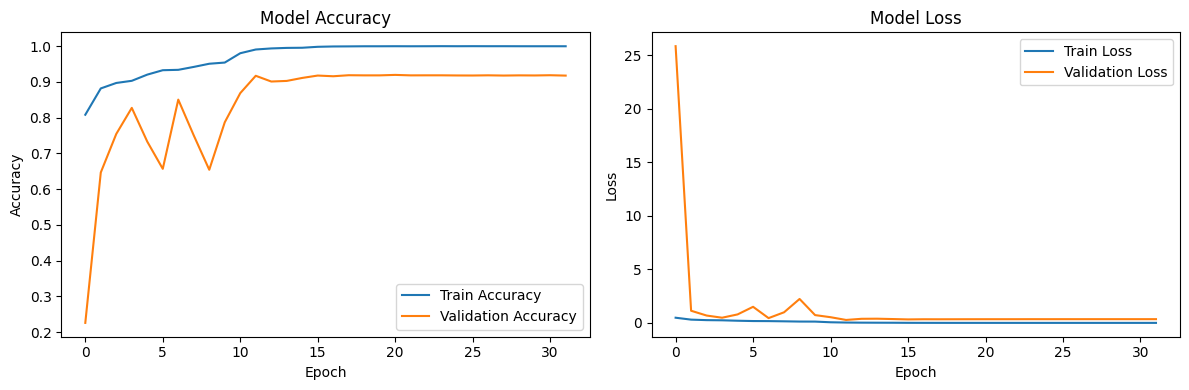

In [12]:
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()